In [1]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

<function matplotlib.pyplot.show(*args, **kw)>

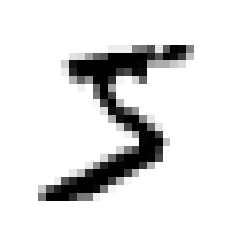

In [5]:
some_digit =X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show

In [6]:
y[0]

'5'

In [7]:
y = y.astype(np.uint8)

In [8]:
y[0]

5

In [9]:
x_train, x_test, y_train,y_test = X[:60000], X[600000:], y[:60000],y[60000:]


TRAINING A BINARY CLASSIFIER

Either the numer is a 5, or not a 5

In [10]:
y_train_5 = (y_train==5) #True for all 5's, false for other digits
y_test_5 = (y_test==5)

Pick a Classifier 

Good place to start is a Stochasitc Gradient Descent(DSG) Classifier
This classifier is capable of handling very large datasets efficiently. This is partly due to SGD dealing with training instances independently, one at a time, which also makes it well suited for online learning. Let us create an SGDClassifier and train it on the whole training set:

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

This wasn't too difficult, as the data and the classifier were both prepared and readily available to us(We also made this test binary in nature). In this case the trickier part will be to evaluate the performace of said classifier compared to that of a regressor.

First way of measurin accuracy will be through Cross-Validation, like we "used" in chapter 2.

Below is a direct implementation of cross-validation, it is straightforward and does roughly the same thing as cross_val_score() function and prints the same result.

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [14]:
num_folds = 10
skfolds = StratifiedKFold(n_splits = num_folds, random_state=42,shuffle=True)
for train_index,test_index in skfolds.split(x_train,y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_folds = x_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = x_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9646666666666667
0.9633333333333334
0.9703333333333334
0.9521666666666667
0.9518333333333333
0.9601666666666666
0.9728333333333333
0.9676666666666667
0.9661666666666666
0.9665


In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [16]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1), dtype=bool)


In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

90% accuracy is actually quite terrible once we realize that the dataset is skewed to 90% not 5 and 10% 5, so if the algorithm just guesses not-5 it should get a 90% accuracy rate. 

That being said, it is clear the accuracy isnt the best performance measure for classifiers, especially when we have skewed datasets.

A better metric would be to look at the confusion matrix. The idea is to count the number of times instances of class A are classified as class B(i.e. when 5's are said to be 3's)

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,x_train,y_train_5,cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Top left are True Negatives, Top Right are False Positives

Bottom left are False Negatives, Bottom Right are True Positives 

In [20]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)
#This is the % of 5's that are actually 5's in the y_train_pred set

0.8370879772350012

In [21]:
recall_score(y_train_5,y_train_pred)
#This is the % 5's in total that are in the y_train_pred set

0.6511713705958311

It would be convenient to combine precision and recall into a single metric called the F1 score, if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall given by the following equation

F1 = 2/((1/precision) + (1/recall))

F1 = 2 * (precision * recall)/(precision + recall)

F1 = TP/(TP + (FN+FP)/2)

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

There is a concept called precision/recall tradeoff. Where increasing precision reduces recall and vice versa, but in different situations, you may care about precision more and others you might care about recall more. It just depends on the application and which error you care about more.

This is due to the conccept of a threshold, where all numbers are lined up on a line, with the threshold moving between a median set of values. The threshold exists between 100% precision and 100% recall. Where the 100% precision will have the lowest recall value, and the 100% recall threshold will have the lowest precision value. But as one moves the threshold to the opposite end, the high stat will get low, and the low stat will get high.

While I can't set the threshold directly, but it does give access to the decision scores that scikit uses to make predicitions.

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,method="decision_function")

In [27]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

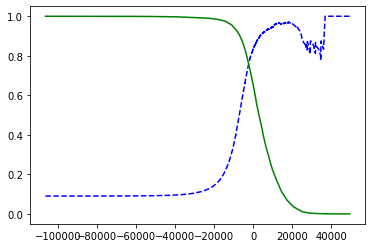

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= .90)]
threshold_90_precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

Receiver Operating Characteristic(ROC) curve is another common tool used with binary classifiers. It is quite similar to the prec/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate agains the false positive rate. The FPR is the ratio of negative instances that are incorrectly classified as positive, which is also called the specificity.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

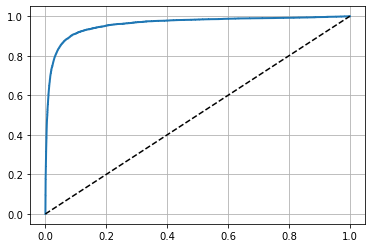

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--')
    plt.grid()
    #plt.()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

PR vs ROC

PR is preferred whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.

Let us train a RFClassifier and compare its ROC and ROC AUC score to the SGDClassifier. Instead of having a decision_function() it should have a predict_proba() method where the output is an array containing a row per instance and a column per class, each containing the probablity that the given instance belongs to the given class.


In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train,y_train_5, cv=3, method="predict_proba")


<function matplotlib.pyplot.show(*args, **kw)>

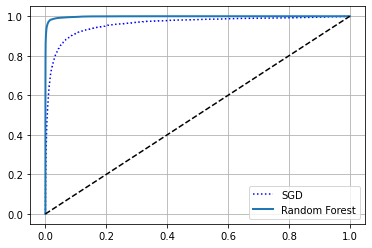

In [36]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
y_train_5_cont = y_train_5 *1.0
y_train_5_cont

array([1., 0., 0., ..., 1., 0., 0.])

In [39]:
#recall_score(y_train_5_cont, y_scores_forest)

Multiclass Classification

There are Classifiers that are purely binary, and others that can work with multiclass. But theres a way to simply use a series of binary classifiers to represent multiple classes, this is called OvA strategy. But this may take more time to run through the data.

Another strategy is to train a binary classifier for every pair of digits, 0&1 0&2 1&2 etc. For N classes you would need N * N-1 classifiers, but these only need to be trained on the sets of data which they cover(1&2 classifier only needs to be trained on data of 1 & 2 class). This is the OvO one v one strategy.

In [40]:
sgd_clf.fit(x_train,y_train)
sgd_clf.predict([some_digit])


array([3], dtype=uint8)

In [41]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
np.argmax(some_digit_scores)

3

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [44]:
sgd_clf.classes_[5]

5

This is a OvA classifier, Scikit automatically detects the presence of multiple classes in the result set and runs OvA. You can force ScikitLearn to use OvO or OvA by runnin the OneVsOneClassifier or OneVsRestClassifier classes. Just create an instance of the classifier and pass a binary classifier to its constructor


In [45]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train,y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [46]:
len(ovo_clf.estimators_)

45

In [47]:
forest_clf.fit(x_train,y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [49]:
cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [50]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train,cv=3,scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [51]:
y_train_pred = cross_val_predict(sgd_clf,x_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)

In [52]:
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

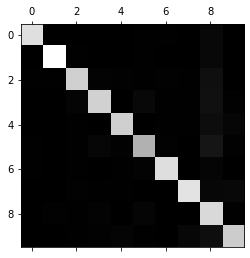

In [53]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

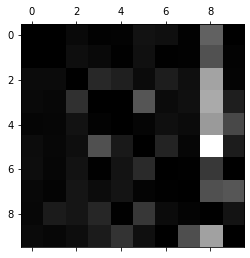

In [54]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

In [55]:
import matplotlib

In [56]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

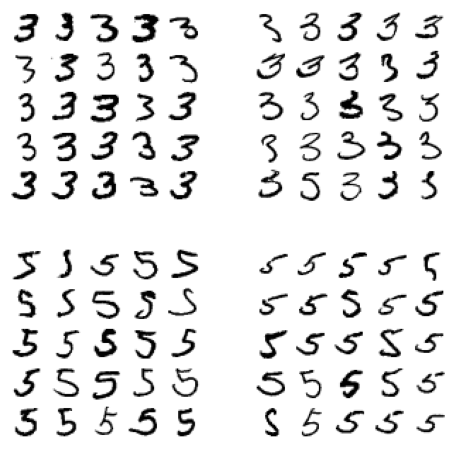

In [57]:
cl_a, cl_b = 3, 5
X_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

Prior to this all of the classifiers only had one potential output class, either the number was a 1 or a 2 or a 3, etc. But what if you want to classify which numbers are in a 2 digit, or whose faces are in a family photo? You'd need multilabel classification for this, where it outputs multiple binary tags(hot encoded for the numbers, 0/1's to show who is present in which pictures.

In [58]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train %2 == 1)
y_multilabel = np.c_[y_train_large,y_train_odd]

#type(y_multilabel)

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

knn_clf.predict([some_digit])

array([[False,  True]])

We can evaluate a multilabel classifier using many metrics, it usually depends on the project. In this case we will use the F1 score average across all labels. But this assumes that all labels are equally important, which may not be the case. If we wanted to do weighting based on the number of instances of that label, just set average="weighted" in the below code.

In [59]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=2)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9735086054032637

In [60]:
noise = np.random.randint(0,100,(len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0,100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test
print(x_test)

[]


In [61]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[0]])
plot_digit(clean_digit)

IndexError: index 0 is out of bounds for axis 0 with size 0